# Importing Necessary Libraries

In [3]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split as tts , RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
train_df = pd.read_csv('train.csv') #read the train data

In [5]:
train_df.head() #checking the first five values from dataset

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529544,High_spent_Small_value_payments,312.4940887,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.2802216,Low_spent_Large_value_payments,284.6291625,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.69952126,Low_spent_Medium_value_payments,331.2098629,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580744,Low_spent_Small_value_payments,223.4513097,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.42015309,High_spent_Medium_value_payments,341.489231,Good


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

# Modifying the dataset

# Annual_Income Update

In [7]:
# Update/Remove garbage values in the 'Annual_Income' column 
train_df['Annual_Income'] = train_df['Annual_Income'].str.rstrip('_')

In [8]:
# Convert 'Annual_Income' column to float
train_df['Annual_Income'] = train_df['Annual_Income'].astype(float)

# Monthly_Inhand_Salary update

In [9]:
most_common_Monthly_Inhand_Salary = train_df.groupby('Customer_ID')['Monthly_Inhand_Salary'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Monthly_Inhand_Salary'] = train_df['Customer_ID'].map(most_common_Monthly_Inhand_Salary)



# Num_Bank_Accounts update

In [10]:
def replace_Num_Bank_Accounts(x):
    zero = 0
    value_counts = x.value_counts()
    if 0 in value_counts:
        value_counts = value_counts.drop(0)
        if not value_counts.empty:
            return value_counts.idxmax()
        else:
            return zero
    else:
        return value_counts.idxmax()

In [11]:
most_common_Num_Bank_Accounts = train_df.groupby('Customer_ID')['Num_Bank_Accounts'].apply(replace_Num_Bank_Accounts)

# Map the most common values back to the original DataFrame
train_df['Num_Bank_Accounts'] = train_df['Customer_ID'].map(most_common_Num_Bank_Accounts)

# Remove the rows have Num_Bank_Accounts = 0
train_df = train_df[train_df['Num_Bank_Accounts'] != 0]

# Num_Credit_Card update

In [12]:
most_common_num_credit_card = train_df.groupby('Customer_ID')['Num_Credit_Card'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Num_Credit_Card'] = train_df['Customer_ID'].map(most_common_num_credit_card)


# Interest_Rate update

In [13]:
most_common_Interest_Rate = train_df.groupby('Customer_ID')['Interest_Rate'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Interest_Rate'] = train_df['Customer_ID'].map(most_common_Interest_Rate)

# Num_of_Loan update

In [14]:
# Update/Remove garbage values in the 'Num_of_Loan' column 
train_df['Num_of_Loan'] = train_df['Num_of_Loan'].str.rstrip('_')

# Update'Num_of_Loan' column to int type
train_df['Num_of_Loan'] = train_df['Num_of_Loan'].astype(int)

In [15]:
most_common_Num_of_Loan = train_df.groupby('Customer_ID')['Num_of_Loan'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Num_of_Loan'] = train_df['Customer_ID'].map(most_common_Num_of_Loan)


# Type_of_Loan update

In [16]:
# Fill null values in the 'Type_of_Loan' column with 'empty String'
train_df['Type_of_Loan'] = train_df['Type_of_Loan'].fillna('Not Specified')

most_common_Type_of_Loan = train_df.groupby('Customer_ID')['Type_of_Loan'].agg(lambda x: x.value_counts().idxmax())

# Map the most common values back to the original DataFrame
train_df['Type_of_Loan'] = train_df['Customer_ID'].map(most_common_Type_of_Loan)

# Delay_from_due_date update

In [17]:
# remove negative values from the 'Delay_from_due_date' column
train_df = train_df[train_df['Delay_from_due_date'] >= 0]


# Num_of_Delayed_Payment update

In [18]:
# Update/Remove garbage values in the 'Num_of_Delayed_Payment' column 
train_df['Num_of_Delayed_Payment'] = train_df['Num_of_Delayed_Payment'].str.rstrip('_')

# drop the NaN values from Num_of_Delayed_Payment
train_df.dropna(subset=['Num_of_Delayed_Payment'], inplace=True)

# Update'Num_of_Delayed_Payment' column to int type
train_df['Num_of_Delayed_Payment'] = train_df['Num_of_Delayed_Payment'].astype(int)

# Delete the values less than 0 from Num_of_Delayed_Payment
train_df = train_df[train_df['Num_of_Delayed_Payment'] >= 0]

# Remove the column has 'Num_of_delayed_Payemnt' more than 30
train_df = train_df[train_df['Num_of_Delayed_Payment'] <= 30]


# Changed_Credit_Limit update

In [19]:
#remove garbage value from 'Changed_Credit_Limit'
train_df['Changed_Credit_Limit'] = train_df['Changed_Credit_Limit'].replace('_', '')

# Remove rows with empty strings
train_df = train_df[train_df['Changed_Credit_Limit'] != '']

#Update 'Changed_Credit_Limit' to float type
train_df['Changed_Credit_Limit'] = train_df['Changed_Credit_Limit'].astype(float)

# remove the data contains negative value
train_df = train_df[train_df['Changed_Credit_Limit'] >= 0]

# Num_Credit_Inquiries update

In [20]:
# Remove NaN values
train_df.dropna(subset=['Num_Credit_Inquiries'], inplace=True)

# Remove Num_Credit_Inquiries values are greater than average
train_df = train_df[train_df['Num_Credit_Inquiries'] <= 31]


# Credit_Mix update

In [21]:
def replace_credit_mix(x):
    value_counts = x.value_counts()
    if '_' in value_counts:
        value_counts = value_counts.drop('_')
        if not value_counts.empty:
            return value_counts.idxmax()
        else:
            return 'not specified'
    else:
        return value_counts.idxmax()

most_common_values = train_df.groupby('Customer_ID')['Credit_Mix'].apply(replace_credit_mix)
train_df['Credit_Mix'] = train_df['Customer_ID'].map(most_common_values)

# Outstanding_Debt update

In [22]:
# fill the garbage values with orginal string
train_df['Outstanding_Debt'] = train_df['Outstanding_Debt'].str.rstrip('_')

#update Outstanding_Debt column from object to float
train_df['Outstanding_Debt'] = train_df['Outstanding_Debt'].astype(float)


In [23]:
#Credit_Utilization_Ratio #okay

# Credit_History_Age update

In [24]:
train_df['Credit_History_Age'].isnull().sum()

7330

In [25]:
# Remove NaN values
train_df.dropna(subset=['Credit_History_Age'], inplace=True)

# Payment_of_Min_Amount update

In [26]:
def replace_Payment_of_Min_Amount(x):
    value_counts = x.value_counts()
    if 'NM' in value_counts:
        value_counts = value_counts.drop('NM')
        if not value_counts.empty:
            return value_counts.idxmax()
    else:
        return value_counts.idxmax()

most_common_values = train_df.groupby('Customer_ID')['Payment_of_Min_Amount'].apply(replace_Payment_of_Min_Amount)
train_df['Payment_of_Min_Amount'] = train_df['Customer_ID'].map(most_common_values)

# Total_EMI_per_month update

In [27]:
def replace_Total_EMI_per_month(x):
    zero = 0
    value_counts = x.value_counts()
    if 0 in value_counts:
        value_counts = value_counts.drop(0)
        if not value_counts.empty:
            return value_counts.idxmax()
        else:
            return zero        
    else:
        return value_counts.idxmax()

most_common_Total_EMI_per_month = train_df.groupby('Customer_ID')['Total_EMI_per_month'].apply(replace_Total_EMI_per_month)

train_df['Total_EMI_per_month'] = train_df['Customer_ID'].map(most_common_Total_EMI_per_month)

In [28]:
train_df['Total_EMI_per_month'] = train_df['Total_EMI_per_month'].apply(lambda x: x / 100 if x > 1000 else x)

# Amount_invested_monthly update

In [29]:
# Remove NaN values
train_df.dropna(subset=['Amount_invested_monthly'], inplace=True)

#update garbage value to it's orginal form
train_df = train_df[train_df['Amount_invested_monthly'] != '__10000__']

#update column into float type from object type
train_df['Amount_invested_monthly'] = train_df['Amount_invested_monthly'].astype(float)

# Payment_Behaviour update

In [30]:
train_df['Payment_Behaviour'] = train_df['Payment_Behaviour'].replace('!@9#%8', 'Not Specified')

# Monthly_Balance update

In [31]:
# Remove NaN values
train_df.dropna(subset=['Monthly_Balance'], inplace=True)

# Remove the garbage value
train_df = train_df[train_df['Monthly_Balance'] != '__-333333333333333333333333333__']

#update column into float type from object type
train_df['Monthly_Balance'] = train_df['Monthly_Balance'].astype(float)


In [32]:
train_df.shape

(66931, 28)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66931 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        66931 non-null  object 
 1   Customer_ID               66931 non-null  object 
 2   Month                     66931 non-null  object 
 3   Name                      60224 non-null  object 
 4   Age                       66931 non-null  object 
 5   SSN                       66931 non-null  object 
 6   Occupation                66931 non-null  object 
 7   Annual_Income             66931 non-null  float64
 8   Monthly_Inhand_Salary     66931 non-null  float64
 9   Num_Bank_Accounts         66931 non-null  int64  
 10  Num_Credit_Card           66931 non-null  int64  
 11  Interest_Rate             66931 non-null  int64  
 12  Num_of_Loan               66931 non-null  int32  
 13  Type_of_Loan              66931 non-null  object 
 14  Delay_from_

 **Dropping some unnecessary features**

In [34]:
train_df = train_df.drop(['ID','Name','Age','SSN','Occupation'],axis = 'columns')

In [35]:
train_df.head()

,Customer_ID,Month,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,January,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,Good,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
3,CUS_0xd40,April,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
5,CUS_0xd40,June,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,...,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172,Not Specified,340.479212,Good
6,CUS_0xd40,July,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,Good,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
8,CUS_0x21b1,January,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,...,Good,605.03,24.464031,26 Years and 7 Months,No,18.816215,104.291825,Low_spent_Small_value_payments,470.690627,Standard


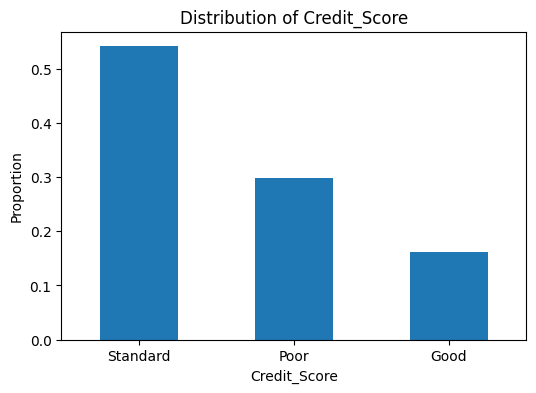

Class Proportions:
Credit_Score
Standard    0.541154
Poor        0.297485
Good        0.161360
Name: proportion, dtype: float64


In [36]:
import matplotlib.pyplot as plt

# Calculate class proportions
class_proportions = train_df['Credit_Score'].value_counts(normalize=True)

# Visualize class distribution
plt.figure(figsize=(6, 4))
class_proportions.plot(kind='bar')
plt.title('Distribution of Credit_Score')
plt.xlabel('Credit_Score')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

# Print class proportions
print("Class Proportions:")
print(class_proportions)


# Apply Encoding 

In [37]:
encoder = LabelEncoder()
scaler = StandardScaler()

In [38]:
categorical_features = ['Customer_ID','Month', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour','Credit_Score']

# Apply preprocessing to each column based on dtype
for col in train_df.columns:
    if train_df[col].dtype == 'object' and col in categorical_features:
        train_df[col] = encoder.fit_transform(train_df[[col]])
    elif train_df[col].dtype in ['int64', 'float64']:
        train_df[col] = scaler.fit_transform(train_df[[col]])



In [39]:
train_df

,Customer_ID,Month,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,11852,3,-0.109192,-0.721671,-0.097146,-0.782736,-1.372652,4,128,-1.263193,...,1,-0.559645,-1.067920,180,0,-0.497904,-0.578473,2,-0.400888,0
3,11852,0,-0.109192,-0.721671,-0.097146,-0.782736,-1.372652,4,128,-1.128536,...,1,-0.559645,-0.173379,185,0,-0.497904,0.084028,5,-0.827524,0
5,11852,5,-0.109192,-0.721671,-0.097146,-0.782736,-1.372652,4,128,-0.926550,...,1,-0.559645,-0.981585,187,0,-0.497904,-0.678564,6,-0.266801,0
6,11852,4,-0.109192,-0.721671,-0.097146,-0.782736,-1.372652,4,128,-1.263193,...,1,-0.559645,-1.909396,188,0,-0.497904,-0.033477,5,-0.726359,0
8,1025,3,-0.098301,-0.331703,-0.110341,-0.782736,-1.029040,1,678,-1.263193,...,1,-0.734898,-1.531090,236,0,-0.746132,-0.445594,5,0.357088,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,8484,6,-0.094992,-0.228379,-0.083950,0.191170,-0.914503,2,677,-0.118606,...,1,-0.822674,1.386969,306,0,-0.614687,-0.243634,1,0.067525,1
99995,8484,0,-0.094992,-0.228379,-0.083950,0.191170,-0.914503,2,677,0.083379,...,1,-0.822674,0.471856,307,0,-0.614687,-0.686683,0,0.401052,1
99996,8484,7,-0.094992,-0.228379,-0.083950,0.191170,-0.914503,2,677,-0.253264,...,1,-0.822674,1.630880,308,0,-0.614687,-0.724445,1,0.481477,1
99997,8484,5,-0.094992,-0.228379,-0.083950,0.191170,-0.914503,2,677,0.352694,...,1,-0.822674,1.766358,309,0,-0.614687,-0.892278,0,0.578058,1


# Split the dataset

In [40]:
x = train_df.drop('Credit_Score',axis = 1) #storing data to x without Credit_Score
y = train_df['Credit_Score'] # Storing only Credit_Score to y


In [41]:
xtrain,xtest,ytrain,ytest = tts(x,y,test_size = 0.2,random_state = 42)

# Variables for storing Model Name and Accuracy


In [42]:
Model_Names=[]
Accuracy_Scores=[]

# Applying Different Model and Evaluate Performance

In [43]:
# Define a dictionary of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Balanced Random Forest": BalancedRandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42), 
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42),
}

# Loop through classifiers and evaluate them
for model_name, model in classifiers.items():
    model.fit(xtrain, ytrain)  
    y_pred = model.predict(xtest)  

    # Storing model names and Accuracy
    result = classification_report(ytest, y_pred, output_dict = True)
    Model_Names.append(model_name)
    Accuracy_Scores.append(result['accuracy'])

    # Display the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(ytest, y_pred))
    print("=" * 60,'\n') 

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.46      0.27      0.34      2125
           1       0.55      0.10      0.17      3968
           2       0.57      0.90      0.70      7294

    accuracy                           0.56     13387
   macro avg       0.53      0.42      0.40     13387
weighted avg       0.55      0.56      0.49     13387


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2125
           1       0.78      0.82      0.80      3968
           2       0.83      0.81      0.82      7294

    accuracy                           0.80     13387
   macro avg       0.79      0.79      0.79     13387
weighted avg       0.80      0.80      0.80     13387


Classification Report for Balanced Random Forest:
              precision    recall  f1-score   support

           0       0.57      0.86      0.69

# Hyperparameter Optimization of Random Forest for Randomized Search

In [44]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
}

In [45]:
rf_rs = RandomizedSearchCV(estimator = RandomForestClassifier(random_state = 42), 
                            param_distributions = rf_params, n_iter = 10, cv = 5)
rf_rs.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]})

In [46]:
rf_rs.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': False}

In [47]:
y_predrf_rs = rf_rs.predict(xtest)

# Storing model names and Accuracy
result = classification_report(ytest, y_predrf_rs, output_dict = True)
Model_Names.append('HyperParams Random Search with Random Forest')
Accuracy_Scores.append(result['accuracy'])

print('Classification Report\n\n', classification_report(ytest,y_predrf_rs))

Classification Report

               precision    recall  f1-score   support

           0       0.73      0.75      0.74      2125
           1       0.79      0.81      0.80      3968
           2       0.83      0.81      0.82      7294

    accuracy                           0.80     13387
   macro avg       0.78      0.79      0.79     13387
weighted avg       0.80      0.80      0.80     13387



# Hyperparameter Optimization of AdaBoost for Randomized Search

In [48]:
ada_params = {
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.0001, 0.001, 1.0],
    'algorithm' : ['SAMME', 'SAMME.R']
}

In [49]:
Ada_Boost = AdaBoostClassifier(random_state = 42)
AdaBoost_rs = RandomizedSearchCV(estimator = Ada_Boost, param_distributions = ada_params, 
                                 n_iter = 10, cv = 5)
AdaBoost_rs.fit(xtrain,ytrain)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.0001, 0.001, 1.0],
                                        'n_estimators': [100, 200, 300]})

In [50]:
y_predAdaBoost_rs = AdaBoost_rs.predict(xtest)

# Storing model names and Accuracy
result = classification_report(ytest, y_predAdaBoost_rs, output_dict = True)
Model_Names.append('HyperParams Random Search AdaBoost')
Accuracy_Scores.append(result['accuracy'])

print('Classification Report\n\n', classification_report(ytest,y_predAdaBoost_rs))

Classification Report

               precision    recall  f1-score   support

           0       0.54      0.56      0.55      2125
           1       0.67      0.60      0.63      3968
           2       0.71      0.75      0.73      7294

    accuracy                           0.68     13387
   macro avg       0.64      0.64      0.64     13387
weighted avg       0.67      0.68      0.67     13387



# Hyperparameter Optimization of XGBoost for GRID Search

In [63]:
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 7],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.0, 0.1, 0.2],
    'min_child_weight': [1, 2],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    }

In [ ]:
xgb_gs = GridSearchCV(XGBClassifier(random_state = 42),xgb_params, cv = 5)

xgb_gs.fit(xtrain,ytrain)

In [ ]:
y_predxgb_gs = xgb_gs.predict(xtest)

# Storing model names and Accuracy
result = classification_report(ytest, y_predxgb_gs, output_dict = True)
Model_Names.append('HyperParams Grid Search XGBoost')
Accuracy_Scores.append(result['accuracy'])

print('Classification Report\n\n', classification_report(ytest,y_predxgb_gs))

# Cross Validation & SMOTE

In [51]:
k_fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
count = 1
for train_index, test_index in k_fold.split(x,y):
    xtrain, xtest = x.iloc[train_index], x.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

    # Initialize SMOTE 
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Apply SMOTE to the training data
    xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)
    
    # Loop through classifiers and evaluate them
    for model_name, model in classifiers.items():
        model.fit(xtrain_resampled,ytrain_resampled)  
        y_pred = model.predict(xtest)  
    
        # Storing model names and Accuracy
        result = classification_report(ytest, y_pred, output_dict = True)
        Model_Names.append('Cross Val'+str(count)+' '+model_name)
        Accuracy_Scores.append(result['accuracy'])
    
        # Display the classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(ytest, y_pred))
        print("=" * 60,'\n')    
    count += 1

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.35      0.64      0.46      2700
           1       0.57      0.58      0.58      4978
           2       0.68      0.51      0.58      9055

    accuracy                           0.55     16733
   macro avg       0.53      0.58      0.54     16733
weighted avg       0.59      0.55      0.56     16733


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72      2700
           1       0.77      0.82      0.80      4978
           2       0.85      0.77      0.81      9055

    accuracy                           0.79     16733
   macro avg       0.76      0.79      0.77     16733
weighted avg       0.79      0.79      0.79     16733


Classification Report for Balanced Random Forest:
              precision    recall  f1-score   support

           0       0.66      0.78      0.72

# Applying PCA

In [52]:
from sklearn.decomposition import PCA

In [53]:
# Initialize PCA with the number of components you want to keep
n_components = 15
pca = PCA(n_components=n_components)

# Fit and transform your dataset
x_pca = pca.fit_transform(x)

### Splitting dataset after PCA 

In [54]:
xtrain_pca,xtest_pca,ytrain_pca,ytest_pca = tts(x,y,test_size = 0.2,random_state = 42)

# Cross Validation and Smote after applying PCA

In [55]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
count = 1
for train_index, test_index in k_fold.split(x_pca,y):
    xtrain_pca, xtest_pca = x.iloc[train_index], x.iloc[test_index]
    ytrain_pca, ytest_pca = y.iloc[train_index], y.iloc[test_index]

    # Initialize SMOTE 
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Apply SMOTE to the training data
    xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain_pca, ytrain_pca)

    # Loop through classifiers and evaluate them
    for model_name, model in classifiers.items():
        model.fit(xtrain_resampled,ytrain_resampled)  
        y_pred = model.predict(xtest_pca)  
    
        # Storing model names and Accuracy
        result = classification_report(ytest_pca, y_pred, output_dict = True)
        Model_Names.append('PCA'+str(count)+' '+model_name)
        Accuracy_Scores.append(result['accuracy'])
    
        # Display the classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(ytest_pca, y_pred))
        print("=" * 60,'\n')    
    count += 1
    

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.35      0.66      0.46      2160
           1       0.57      0.60      0.59      3983
           2       0.68      0.48      0.57      7244

    accuracy                           0.55     13387
   macro avg       0.54      0.58      0.54     13387
weighted avg       0.60      0.55      0.56     13387


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71      2160
           1       0.77      0.82      0.80      3983
           2       0.84      0.77      0.80      7244

    accuracy                           0.79     13387
   macro avg       0.76      0.79      0.77     13387
weighted avg       0.79      0.79      0.79     13387


Classification Report for Balanced Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72

# Combined Over  and Under Sampling

**WE split x,y to train & test above for this part**

In [58]:
# Step 1: Oversampling with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_oversampled, y_oversampled = smote.fit_resample(xtrain, ytrain)

# Step 2: Undersampling with Cluster Centroids
cluster_centroids = ClusterCentroids(sampling_strategy='auto', random_state=42)
x_combined, y_combined = cluster_centroids.fit_resample(x_oversampled, y_oversampled)

### Evaluate the performance after Combined Sampling

In [59]:
for model_name, model in classifiers.items():
    model.fit(x_combined, y_combined)  
    y_pred = model.predict(xtest)  

    # Storing model names and Accuracy
    result = classification_report(ytest, y_pred, output_dict = True)
    Model_Names.append('Combined Sampling'+' '+model_name)
    Accuracy_Scores.append(result['accuracy'])

    # Display the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(ytest, y_pred))
    print("=" * 60,'\n')

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.35      0.66      0.46      2700
           1       0.58      0.55      0.57      4977
           2       0.67      0.51      0.57      9055

    accuracy                           0.55     16732
   macro avg       0.53      0.57      0.53     16732
weighted avg       0.59      0.55      0.55     16732


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72      2700
           1       0.78      0.82      0.80      4977
           2       0.85      0.78      0.81      9055

    accuracy                           0.79     16732
   macro avg       0.77      0.79      0.78     16732
weighted avg       0.80      0.79      0.79     16732


Classification Report for Balanced Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72

# UnderSampling

In [60]:
UnderSampling = RandomUnderSampler(sampling_strategy='auto', random_state=42)
xtrain_UnderSample,ytrain_UnderSample = UnderSampling.fit_resample(xtrain,ytrain)

# Applying SVM after UnderSampling 

In [62]:
svm = SVC(kernel='linear')
svm.fit(xtrain_UnderSample,ytrain_UnderSample)

SVC(kernel='linear')

In [63]:
ypred_svm = svm.predict(xtest)

# Storing model names and Accuracy
result = classification_report(ytest, ypred_svm, output_dict = True)
Model_Names.append('Under Sampling SVM')
Accuracy_Scores.append(result['accuracy'])

print("Classification Report:\n")
print(classification_report(ytest, ypred_svm))

Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.82      0.61      2700
           1       0.62      0.70      0.65      4977
           2       0.81      0.59      0.68      9055

    accuracy                           0.66     16732
   macro avg       0.64      0.70      0.65     16732
weighted avg       0.70      0.66      0.66     16732



# Visualize the Accuracy Scores of Different Models

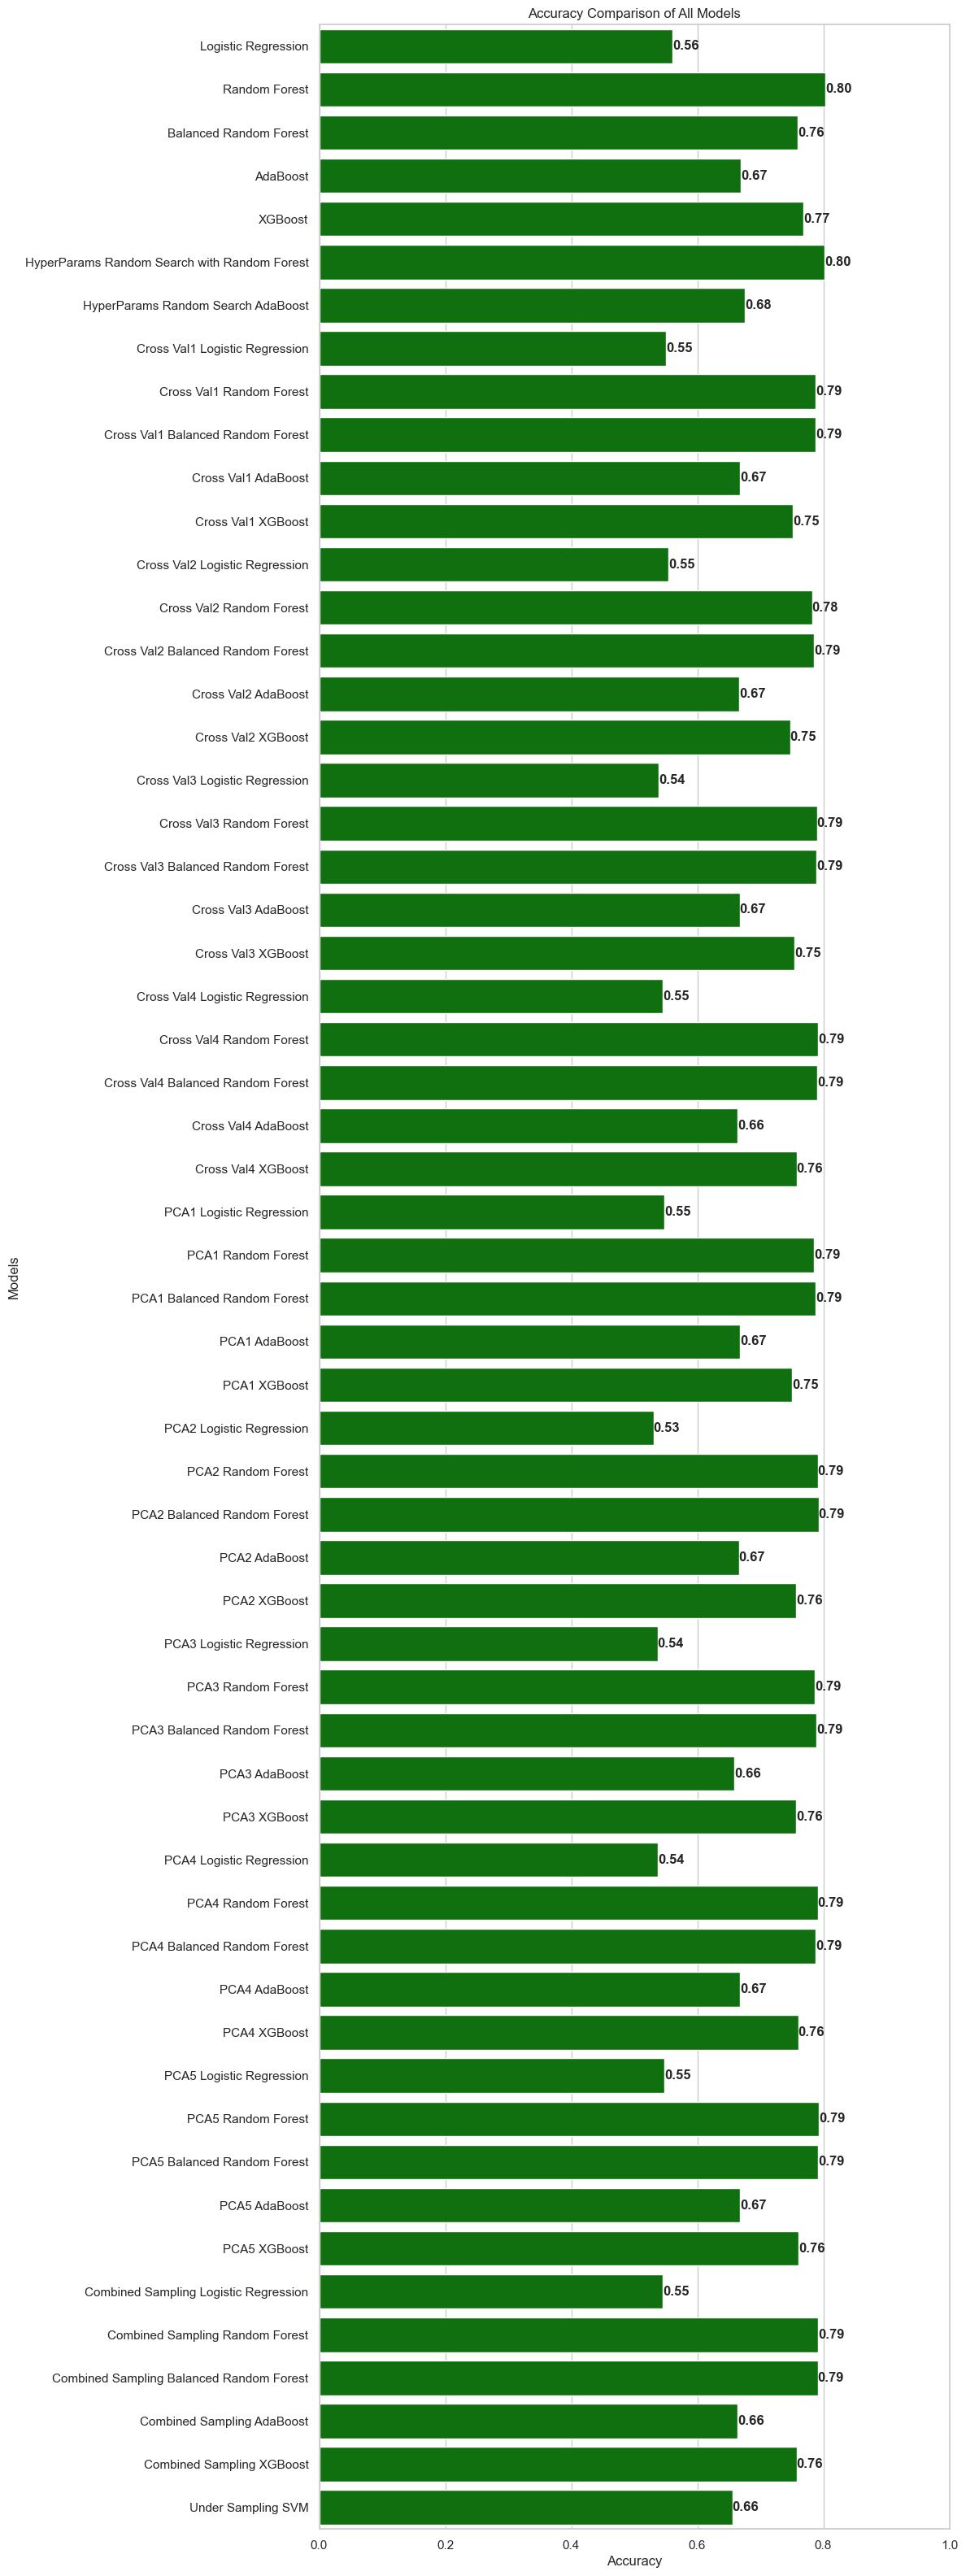

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame to hold the data
data = pd.DataFrame({'Model': Model_Names, 'Accuracy': Accuracy_Scores})

# Set the style of the plot using Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(10,40))
ax = sns.barplot(x="Accuracy", y="Model", data=data, color="green")
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Accuracy Comparison of All Models')
plt.xlim(0, 1)  # Set the limit of x to 1 because accuracy is in the range [0, 1]

# Add labels to the bars
for index, row in data.iterrows():
    ax.text(row['Accuracy'], index, f'{row["Accuracy"]:.2f}', ha='left',fontweight= 'bold', va='center')


plt.show()